In [29]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rioxr
import matplotlib.pyplot as plt
from geocube.vector import vectorize
import skimage
import geopandas as gpd
from tqdm.notebook import tqdm
from functools import reduce
import sys

In [30]:
roi_path, roi_layer = "F:/ESimonson_Workspace/_Projects/RCW_HomeRange/RCW_HomeRange.gdb", "RedHills_Region"

data_dir = "F:/RMonaghan_Workspace/Projects_Main/RCW_HomeRange/Data/tifs_Projected_Clipped/"

layers = [["NLCD_LandCover", "LC"],
          ["NLCD_TreeCanopy", "TC"],
          ["LandFire_Canopy_Base_Height_2020", "CBH"],
          ["LandFire_Canopy_Cover_2020", "CC"],
          ["LandFire_Canopy_Height_2020", "CH"],
          ["LandFire_Existing_Vegetation_Type_2020", "EVT"],
          ["LandFire_Natl_Vegetation_Classification", "NVC"],
          ["SEFireMap_FRQ_1994_2022", "FRQ"]]

ext = '.tif'

In [38]:
roi = gpd.read_file(roi_path, layer=roi_layer)
roi_bbox = roi.total_bounds

opened_rasters = [(rioxr.open_rasterio(data_dir + i[0] + ext, mask_and_scale=True).squeeze('band').drop('band')).to_dataset(name=i[1]) for i in layers]

crs = roi.crs
projected_rasters = [i.rio.reproject(crs) for i in opened_rasters]
clipped_rasters = [i.rio.clip_box(roi_bbox[0], roi_bbox[1], roi_bbox[2], roi_bbox[3]) for i in opened_rasters]
reproj_rasters = [i.rio.reproject_match(clipped_rasters[0]) for i in clipped_rasters]

labeled = skimage.measure.label(reproj_rasters[0]['LC'].values.astype(int), connectivity=2, background=0)
group_key = xr.DataArray(labeled.data, coords={'y': reproj_rasters[0].y, 'x': reproj_rasters[0].x}, dims={'y': reproj_rasters[0].y, 'x': reproj_rasters[0].x})

C:\Users\rmonaghan\AppData\Local\Temp\ipykernel_17872\2074639218.py:11: RuntimeWarning: invalid value encountered in cast
  labeled = skimage.measure.label(reproj_rasters[0]['LC'].values.astype(int), connectivity=2, background=0)


In [46]:
arrays = [i.to_array() for i in reproj_rasters]
vectors = [vectorize(i) for i in arrays]

In [52]:
reproj = [i.set_crs(crs) for i in vectors]
named = []
for name, vector in zip(layers, reproj):
    vector.rename(columns={None:name[1]}, inplace=True)
    named.append(vector)


In [53]:
len(named)

8

In [60]:
first = named[0].reset_index()
first.rename(columns={'index':'ID'}, inplace=True)
sjoined = [i.sjoin(first, how='right') for i in named]

In [64]:
sjoined[2]

index_left    CBH      ID    LC  \
0              215  100.0       0  90.0   
0              216   10.0       0  90.0   
0              361   50.0       0  90.0   
0              362   11.0       0  90.0   
0              363    8.0       0  90.0   
...            ...    ...     ...   ...   
229824      787179   17.0  229824   NaN   
229824      787180   18.0  229824   NaN   
229824      787181    3.0  229824   NaN   
229824      787182   21.0  229824   NaN   
229824      787183    NaN  229824   NaN   

                                                 geometry  
0       POLYGON ((1184176.032 951909.450, 1184176.032 ...  
0       POLYGON ((1184176.032 951909.450, 1184176.032 ...  
0       POLYGON ((1184176.032 951909.450, 1184176.032 ...  
0       POLYGON ((1184176.032 951909.450, 1184176.032 ...  
0       POLYGON ((1184176.032 951909.450, 1184176.032 ...  
...                                                   ...  
229824  POLYGON ((1190913.079 874935.789, 1191296.488 ...  
229824  POLYGON ((1190913.079 874935.789, 1191296.488 ...  
229824  POLYGON ((1190913.079 874935.789, 1191296.488 ...  
229824  POLYGON ((1190913.079 874935.789, 1191296.488 ...  
229824  POLYGON ((1190913.079 874935.789, 1191296.488 ...  

[2542890 rows x 5 columns]

In [78]:
m1 = pd.merge(sjoined[1], sjoined[2], on=['ID', 'LC', 'geometry'])
m2 = pd.merge(m1, sjoined[3], on=['ID', 'LC', 'geometry'])
m3 = pd.merge(m2, sjoined[4], on=['ID', 'LC', 'geometry'])
m4 = pd.merge(m3, sjoined[5], on=['ID', 'LC', 'geometry'])
m5 = pd.merge(m4, sjoined[6], on=['ID', 'LC', 'geometry'])
m6 = pd.merge(m5, sjoined[7], on=['ID', 'LC', 'geometry'])

MemoryError: Unable to allocate 103. GiB for an array with shape (2, 6926880470) and data type float64

In [ ]:
outdir = 'F:/RMonaghan_Workspace/Projects_Main/RCW_HomeRange/Data/Zonal_Statistics'
for i, names in zip(sjoined[1:], layers[1:]):
    name = names[1]
    i.to_parquet(f"{outdir}/ZStats_{name}.parquet.gzip")


In [6]:
groups = []
for i, name in zip(reproj_rasters, layers):
    var = name[1]
    sub = i.copy()
    sub['labels'] = group_key
    groups.append(sub[var].groupby(sub['labels']))

len(groups)

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


8

In [7]:
def mode(x):
    vals, counts = np.unique(x, return_counts=True)
    mode_idx = np.argmax(counts)
    return vals[mode_idx]

def return_mode(groups, raster):
    modes = []
    count = 1
    try:
        print('Calculating majority for' , str([i for i in raster.data_vars][0]) + '.')
        with tqdm(total=len(groups)) as pbar:
            for group in groups:
                for i in range(1, len(group), 1):
                    filt =  group[i].data
                    filt_notnan = filt[~np.isnan(filt)]
                    if filt_notnan.size > 0:
                        majority = mode(filt_notnan)
                        modes.append((majority, group[0]))
                        pbar.update(1)
                    else:
                        pass
                        pbar.update(1)

        print('Replacing data with majority.')
        fillin_arr = group_key.copy().data
        with tqdm(total=len(modes)) as pbar2:
            for val, label in modes:
                fillin_arr[fillin_arr == label] = val
                pbar2.update(1)

        print('Creating data array with majority filter.')
        zstats = xr.DataArray(fillin_arr, coords={'y': group_key.y, 'x': group_key.x},
                              dims={'y': group_key.y, 'x': group_key.x})

        min_max = [(raster[var].min().values, raster[var].max().values) for var in raster]

        zstats.data = np.where(((zstats.data < int(min_max[0][0])) | (zstats.data > int(min_max[0][1]))), 32767, zstats.data)

        count += 1
        print("Done with count #:", count)
        # zstats.fillna(32767, inplace=True)
        # zstats.rio.write_nodata(32767, inplace=True)

        return zstats

    except:
        exception_type, exception_object, exception_traceback = sys.exc_info()
        filename = exception_traceback.tb_frame.f_code.co_filename
        line_number = exception_traceback.tb_lineno

        e = Exception
        print('Error:', e)
        print("Exception type: ", exception_type)
        print("File name: ", filename)
        print("Line number: ", line_number)


In [8]:
outputs = []
for group, raster in zip(groups, reproj_rasters):
    outputs.append(return_mode(group, raster))

Calculating majority for LC.


  0%|          | 0/147423 [00:00<?, ?it/s]

Replacing data with majority.


  0%|          | 0/147419 [00:00<?, ?it/s]

Creating data array with majority filter.
Done with count #: 2
Calculating majority for TC.


  0%|          | 0/147423 [00:00<?, ?it/s]

Replacing data with majority.


  0%|          | 0/147243 [00:00<?, ?it/s]

Creating data array with majority filter.
Done with count #: 2
Calculating majority for CBH.


  0%|          | 0/147423 [00:00<?, ?it/s]

Replacing data with majority.


  0%|          | 0/147423 [00:00<?, ?it/s]

Creating data array with majority filter.
Done with count #: 2
Calculating majority for CC.


  0%|          | 0/147423 [00:00<?, ?it/s]

Replacing data with majority.


  0%|          | 0/147423 [00:00<?, ?it/s]

Creating data array with majority filter.
Done with count #: 2
Calculating majority for CH.


  0%|          | 0/147423 [00:00<?, ?it/s]

Replacing data with majority.


  0%|          | 0/147423 [00:00<?, ?it/s]

Creating data array with majority filter.
Done with count #: 2
Calculating majority for EVT.


  0%|          | 0/147423 [00:00<?, ?it/s]

Replacing data with majority.


  0%|          | 0/147423 [00:00<?, ?it/s]

Creating data array with majority filter.
Done with count #: 2
Calculating majority for NVC.


  0%|          | 0/147423 [00:00<?, ?it/s]

Replacing data with majority.


  0%|          | 0/147423 [00:00<?, ?it/s]

Creating data array with majority filter.
Done with count #: 2
Calculating majority for FRQ.


  0%|          | 0/147423 [00:00<?, ?it/s]

Replacing data with majority.


  0%|          | 0/147367 [00:00<?, ?it/s]

Creating data array with majority filter.
Done with count #: 2


In [9]:
bands = []
for name, output in zip(layers, outputs):
    da = output
    da.rio.write_nodata(32767, inplace=True)
    name = name[1]
    ds = da.to_dataset(name=name).fillna(32767)
    bands.append(ds)

In [10]:
combined = xr.merge(bands)
combined

<xarray.Dataset>
Dimensions:  (y: 1512, x: 1680)
Coordinates:
  * y        (y) float64 9.519e+05 9.518e+05 9.518e+05 ... 8.692e+05 8.692e+05
  * x        (x) float64 1.099e+06 1.099e+06 1.099e+06 ... 1.191e+06 1.191e+06
Data variables:
    LC       (y, x) int64 32767 32767 32767 32767 ... 32767 32767 32767 32767
    TC       (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    CBH      (y, x) int64 0 0 0 0 0 0 0 0 0 ... 100 100 100 100 100 100 100 100
    CC       (y, x) int64 0 0 0 0 0 0 0 0 0 0 ... 65 65 65 65 65 65 65 65 65 65
    CH       (y, x) int64 0 0 0 0 0 0 0 0 0 ... 190 190 190 190 190 190 190 190
    EVT      (y, x) int64 7292 7292 7292 7292 7292 ... 9322 9322 9322 9322 9322
    NVC      (y, x) int64 7994 7994 7994 7994 7994 ... 9322 9322 9322 9322 9322
    FRQ      (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0

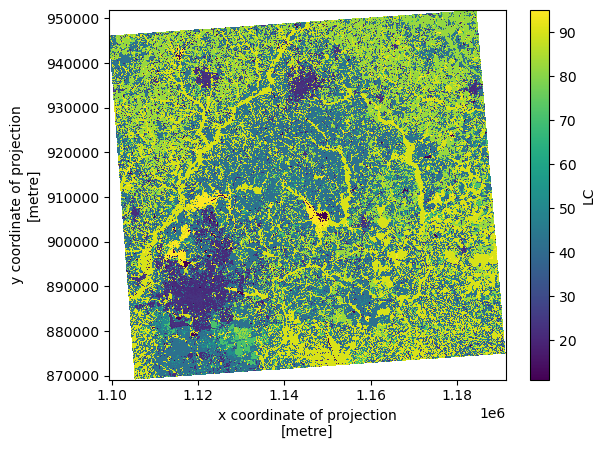

In [32]:
combined['LC'].where(combined['LC'] != 32767).plot()

In [ ]:
vectors = []
for var in combined:
    vector = vectorize(combined[var].astype('int32'))
    vectors.append(vector)

<Axes: >

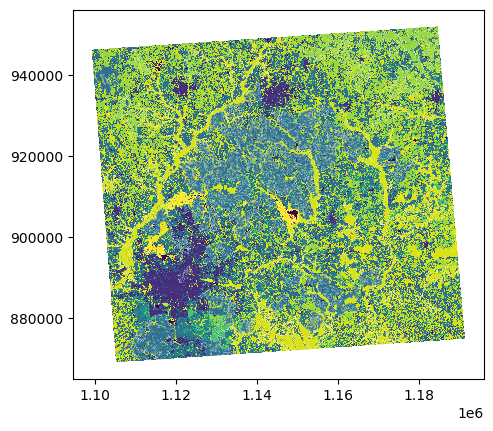

In [12]:
vectors[0].plot(column='LC')

In [27]:
vectors[0]

LC                                           geometry
0       82.0  POLYGON ((1184176.032 951909.450, 1184176.032 ...
1       41.0  POLYGON ((1183354.440 951854.703, 1183354.440 ...
2       21.0  POLYGON ((1183683.077 951854.703, 1183683.077 ...
3       41.0  POLYGON ((1183792.622 951854.703, 1183792.622 ...
4       22.0  POLYGON ((1184011.713 951854.703, 1184011.713 ...
...      ...                                                ...
229697  42.0  POLYGON ((1105248.508 869296.894, 1105248.508 ...
229698  90.0  POLYGON ((1106124.872 870118.092, 1106179.645 ...
229699  42.0  POLYGON ((1106179.645 869461.134, 1106234.418 ...
229700  22.0  POLYGON ((1106617.827 869296.894, 1106617.827 ...
229701  71.0  POLYGON ((1106727.372 869296.894, 1106727.372 ...

[229702 rows x 2 columns]

In [ ]:
# calculate mode for an array -- did not use nanargmax
def mode(x):
    vals, counts = np.unique(x, return_counts=True)
    mode_idx = np.argmax(counts)
    return vals[mode_idx]


# returns grouped object
def group_and_return(patch_raster, data_raster, name):
    try:
        sub = patch_raster.where(patch_raster == 1).squeeze('band').sel(x=data_raster.x, y=data_raster.y).fillna(
            0).astype('int32')
        labeled = skimage.measure.label(sub.data, connectivity=2, background=0)
        labeled_da = xr.DataArray(labeled, coords={'y': sub.y, 'x': sub.x}, dims={'y': sub.y, 'x': sub.x})

        merged = labeled_da.where(labeled_da > 0).to_dataset(name='labels')
        merged[f"{name}"] = (data_raster.dims, data_raster.values, data_raster.attrs, data_raster.encoding)
        grouped = merged[f"{name}"].groupby(merged['labels'], restore_coord_dims=True)

        return grouped, labeled_da

    except:
        print('function group_and_return', get_e())


# computes zonal statistics and outputs raster with majority date
def zonal_stats(grouped, labeled_raster, crs_raster):
    crs = crs_raster.rio.crs

    try:
        modes = []
        for i in range(1, len(grouped), 1):
            filt = grouped[i].values
            filt_notnan = filt[~np.isnan(filt)]
            if filt_notnan.size > 0:
                majority = mode(filt_notnan)
                modes.append((majority, i))

        labeled_raster.data = np.where(labeled_raster.data == 0, np.nan, labeled_raster.data)
        fillin_arr = labeled_raster.data
        for val, label in modes:
            fillin_arr[fillin_arr == label] = val

        zstats = xr.DataArray(fillin_arr, coords={'y': labeled_raster.y, 'x': labeled_raster.x},
                              dims={'y': labeled_raster.y, 'x': labeled_raster.x})
        zstats = zstats.fillna(32767)
        zstats.rio.write_nodata(32767, inplace=True)
        zstats.rio.write_crs(bd.rio.crs)
        zstats = zstats.astype(int)

        min_date = (year - 1) * (10 ** 4)
        zstats.data = np.where(((zstats.data != zstats.rio.nodata) & (zstats.data < min_date)), 0, zstats.data)

        return zstats
    except:
        print('function zonal_stats', get_e())


years = np.arange(1995, 1996, 1)
annual_fp = "F:/RMonaghan_Workspace/Projects_Main/GM/SE_Firemap_BD_LCP/Annual_Rasters"
threshold = 90
flag = 249

outputs = {}

with tqdm(total=len(stacks)) as pbar:
    for year in years:
        try:
            for stack in stacks:
                filenames, dates, doys, patches = subset(stack, year, annual_fp)

                bd = get_dates('BD', filenames, dates, doys, flag, threshold)
                nb = get_dates('NB', filenames, dates, doys, flag, threshold)
                lcp = get_LCP(bd, nb, year, stack, threshold, flag)

                bd_grouped, labeled_da = group_and_return(patches, bd, 'BD')
                lcp_grouped, labeled_da = group_and_return(patches, lcp, 'LCP')

                bd_zstats = zonal_stats(bd_grouped, labeled_da, patches)
                lcp_zstats = zonal_stats(lcp_grouped, labeled_da, patches)

                outputs.append((year, bd_zstats, lcp_zstats))
                pbar.update(1)
        except:
            print('Shoot. Could not process for stack filepath:', stack)
            pbar.update(1)
            pass